## Comprehensive Guide to Running PySpark Jobs on Google Cloud Dataproc Serverless

This guide will walk you through successfully running your `process_data.py` PySpark script using Dataproc Serverless for Spark. We'll cover prerequisites, the updated submission command, and key considerations.

### Definition
 
Dataproc Serverless allows you to run Spark-based batch workloads without needing to provision, configure, or manage your own Dataproc clusters. You simply submit your job, and Google handles the underlying infrastructure, automatically scaling resources up or down as needed.



### Key Benefits

* **No Infrastructure Management:** Eliminates the need to create, configure, scale, or delete clusters.
* **Cost-Effective:** You are billed only for the processing time your workload consumes, with per-second billing and a one-minute minimum charge. This is ideal for intermittent or unpredictable jobs.
* **Autoscaling:** Resources are automatically scaled to meet the demands of your job, ensuring efficient performance without manual tuning.
* **Ease of Use:** Simplifies the process of running Spark jobs to a single command or API call.



### 1\. Prerequisites (Adapted for Serverless)

Before you can run this command, ensure you have the following in place:

  * **Google Cloud Project:** You need an active Google Cloud Project (e.g., `poc-example-ds`).
  * **Billing Enabled:** Ensure billing is enabled for your Google Cloud Project.
  * **gcloud CLI Installed and Authenticated:**
      * If you don't have it, install the Google Cloud SDK: [https://cloud.google.com/sdk/docs/install](https://cloud.google.com/sdk/docs/install)
      * Authenticate your `gcloud` CLI:
        ```bash
        gcloud auth login
        REGION = europe-west1
        gcloud config set dataproc/region $REGION
        PROJECT_ID=$(gcloud config get-value project) && \
        gcloud config set project $PROJECT_ID

        ```
  * **Dataproc API Enabled:**
    ```bash
    gcloud services enable dataproc.googleapis.com
    # Also ensure the Compute Engine API is enabled as Dataproc relies on it
    gcloud services enable compute.googleapis.com
    ```
  * **Cloud Storage Bucket:** A Google Cloud Storage (GCS) bucket (e.g., `gs://my-gcp-bucket/`) to store your PySpark scripts, utility files, and input/output data.
  * **PySpark Scripts:**
      * `process_data.py`: Your main PySpark application script located at `gs://my-gcp-bucket/pyspark_scripts/process_data.py`.
      * `utils.py`: Any utility Python files your main script depends on, located at `gs://my-gcp-bucket/pyspark_scripts/utils.py`.
  * **Data in GCS:** Input data for your PySpark job (e.g., sales data in `gs://my-gcp-bucket/raw_data/sales/`). (As created in the previous answer: `sales_data.csv` in `gs://my-gcp-bucket/raw_data/sales/`).
  * **BigQuery Dataset:** If your job writes to BigQuery, ensure the BigQuery dataset (`my_dataset`) exists.
  * **Dataproc Serverless Runtime Version:** You'll need to specify a runtime version. Dataproc Serverless for Spark uses specific image versions.
      * You can list available versions with: `gcloud dataproc operations list --filter="metadata.type=RUNTIME_VERSION"` (though this lists operations, often the latest runtime version is available without needing to check). A common recent version would be `1.1` or `2.0` (for Spark 3.x). We'll use `1.1` as a common example.
  * **Networking:** Dataproc Serverless runs within a VPC network. While default networks work for basic cases, for production, you might need to configure a specific VPC and subnet, ensuring private Google Access is enabled if not using external IP addresses (common for serverless). For this guide, we'll assume a default setup that allows it.

### 2\. PySpark Script (`process_data.py`) - No Changes Needed\!

The beauty of Dataproc Serverless is that your application code typically requires **no changes**. The `process_data.py` script you provided will work as-is.

### 3\. Understanding the `gcloud dataproc jobs submit spark` Command for Serverless

The `gcloud` command changes slightly for Dataproc Serverless. Instead of `--cluster`, you use `--batches` (for batch workloads) and specify the runtime version and resource allocation.




In [ ]:
gcloud dataproc batches submit pyspark "gs://example-dataproc-workshop/01_2_Submit_Job/pyspark_scripts/process_data.py" \
    --region=europe-west1 \
    --project=poc-example-ds \
    --version=1.1 \
    --py-files="gs://example-dataproc-workshop/01_2_Submit_Job/pyspark_scripts/utils.py" \
    --properties=spark.bigquery.temporaryGcsBucket=example-dataproc-workshop \
    -- \
    --input-path="gs://example-dataproc-workshop/01_2_Submit_Job/raw_data/sales/" \
    --output-table=example_dataproc_workshop.processed_sales \
    --processing-date=2025-06-12
    --history-server-cluster=projects/poc-example-ds/regions/europe-west1/clusters/my-dataproc-history-server-cluster \


**Key Differences and New/Modified Parameters:**

  * **`gcloud dataproc batches submit pyspark`**: This is the new command for submitting a batch PySpark job to Dataproc Serverless.
  * **No `--cluster` flag**: Because it's serverless, you don't attach to a pre-existing cluster.
  * **`--version=1.1`**: This is crucial for Dataproc Serverless. It specifies the Spark runtime environment version. `1.1` is a common version for Spark 3.x. Check Dataproc documentation for the latest available versions.
  * **`--history-server-cluster=... /my-dataproc-history-server-cluster`**: (Optional, but highly recommended for debugging) Dataproc Serverless jobs are ephemeral. To view Spark History Server UI after a job completes, you need a separate, persistent Dataproc cluster configured as a Spark History Server. This flag links your serverless job's logs to that history server.
      * **Setting up a History Server (if you don't have one):**
        ```bash
        gcloud dataproc clusters create my-dataproc-history-server-cluster \
            --region=europe-west1 \
            --single-node \
            --enable-component-gateway \
            --image-version=2.1-debian11 \
            --project=poc-example-ds \
            --properties=spark:spark.history.fs.logDirectory=gs://example-dataproc-workshop/spark-history-logs/
        ```
        You then need to configure your PySpark jobs to write their event logs to this GCS path:
        ```bash
        --history-server-cluster=projects/poc-example-ds/regions/europe-west1/clusters/my-dataproc-history-server-cluster \
        ```


### 4\. Uploading Your Files to GCS

This remains the same as for cluster-based Dataproc:

```bash
gsutil cp process_data.py gs://my-gcp-bucket/pyspark_scripts/process_data.py
gsutil cp utils.py gs://my-gcp-bucket/pyspark_scripts/utils.py
gsutil cp sales_data.csv gs://my-gcp-bucket/raw_data/sales/sales_data.csv # Your input data
```



### 5\. Monitoring Your Serverless Job

  * **gcloud CLI:** After submitting, you'll get a batch ID (e.g., `batch-yourjobid`).
    ```bash
    gcloud dataproc batches describe batch-yourjobid --region=europe-west1
    gcloud dataproc batches wait batch-yourjobid --region=europe-west1 # To wait for job completion
    ```
  * **Google Cloud Console:** Navigate to **Dataproc \> Serverless \> Batches** in your project. You'll see your job listed with its status. Click on it to view details, logs (stdout/stderr of the driver and executors), and links to the Spark History Server UI (if configured).




### APPENDIX
#### What is the Spark History Server?
A **Spark History Server Cluster** (or simply "History Server Cluster" in Dataproc terms) is a dedicated, small, and long-lived Dataproc cluster whose primary purpose is to host the **Spark History Server UI**.


Spark applications generate detailed event logs that record everything that happens during their execution (e.g., job stages, tasks, executors, shuffles, successes, failures). When a Spark application finishes (or is running), you can typically view its progress and details in the Spark UI. However, once a transient cluster (like those used for Dataproc Serverless batches or a short-lived Dataproc cluster) is deleted or the application completes, its Spark UI is no longer accessible.

The **Spark History Server** is a web UI that allows you to view these event logs for **completed or running Spark applications** that have stored their event logs in a persistent storage system, typically Google Cloud Storage (GCS).

#### Why a "Cluster" for a History Server?

While the Spark History Server itself is a single application, in Google Cloud Dataproc, it's typically run on a dedicated, small Dataproc cluster. This cluster:

1.  **Runs the History Server process:** This process continuously monitors a specified GCS bucket for Spark event logs.
2.  **Serves the UI:** It hosts the web interface that parses these logs and presents them in a user-friendly format, showing metrics, DAG visualizations, task details, and more.
3.  **Is Persistent:** Unlike the ephemeral clusters that might run your actual Spark jobs (especially Dataproc Serverless batches), the History Server Cluster needs to remain running so that you can access the historical UIs at any time.

#### How it Works with Dataproc Jobs (especially Serverless)

1.  **Spark Event Logs:** When you run a Spark job (either on a regular Dataproc cluster or a Dataproc Serverless batch), you configure Spark to write its event logs to a specific GCS bucket path (e.g., `gs://your-bucket/spark-history-logs/`). This is done via Spark properties like `spark.eventLog.enabled=true` and `spark.eventLog.dir=gs://your-bucket/spark-history-logs/`.
2.  **History Server Monitoring:** Your dedicated History Server Cluster is configured to read from this *same* GCS bucket path (`spark.history.fs.logDirectory`).
3.  **UI Access:** After your Spark job completes, its event logs are finalized in GCS. You can then navigate to the Spark History Server UI (usually through the Dataproc Console or Component Gateway of your History Server Cluster) and select your completed application's ID to view its detailed historical Spark UI.

#### Key Benefits

* **Debugging:** Critical for understanding why a Spark job failed, pinpointing bottlenecks, or diagnosing performance issues long after the job has finished.
* **Performance Tuning:** Helps analyze execution plans, shuffle stages, and resource utilization to optimize future job runs.
* **Compliance/Auditing:** Provides a historical record of job execution for auditing purposes.
* **Decoupling:** Separates the infrastructure for job execution from the infrastructure for monitoring and analysis, especially valuable for Dataproc Serverless where jobs don't run on a persistent cluster.

#### Typical Configuration

A History Server Cluster is usually a very small Dataproc cluster, often a **single-node cluster** (just a master node without workers), as it doesn't perform any data processing itself. Its primary resource consumption is I/O for reading logs from GCS and serving the web UI.

In essence, a Spark History Server Cluster is your central, always-on "archive reader" and "visualizer" for all your Spark job executions, providing invaluable insights into their behavior.



You're asking how to check the **Spark History Server UI** to see the details of your completed Spark jobs. This is different from checking if the *cluster* itself is running (which you do with `gcloud dataproc clusters describe`).

Assuming you have a Dataproc History Server cluster (`my-dataproc-history-server-cluster`) running and properly configured to store Spark event logs in GCS (as discussed previously using `spark.history.fs.logDirectory`):

### 1. Access the Spark History Server UI via Google Cloud Console

This is the easiest and most common way:

1.  **Go to the Dataproc Clusters page:**
    * Open the Google Cloud Console.
    * Navigate to **Dataproc > Clusters**.
    * Ensure you are in your project (`poc-example-ds`) and region (`europe-west1`).

2.  **Find your History Server Cluster:**
    * Locate your `my-dataproc-history-server-cluster` in the list.
    * Click on its name to go to the "Cluster details" page.

3.  **Access Web Interfaces:**
    * On the Cluster details page, look for the **"Web interfaces"** or **"Web UIs"** tab/section (sometimes under "Component gateway").
    * You should see a link for **"Spark History Server"**. Click on this link.

4.  **View Your Jobs:**
    * The Spark History Server UI will open in a new tab.
    * You'll see a list of all Spark applications whose event logs have been written to the GCS bucket that your history server is monitoring.
    * Find your job (e.g., based on application name or ID like `application_1751462491831_0004`) and click on it to see its detailed Spark UI.
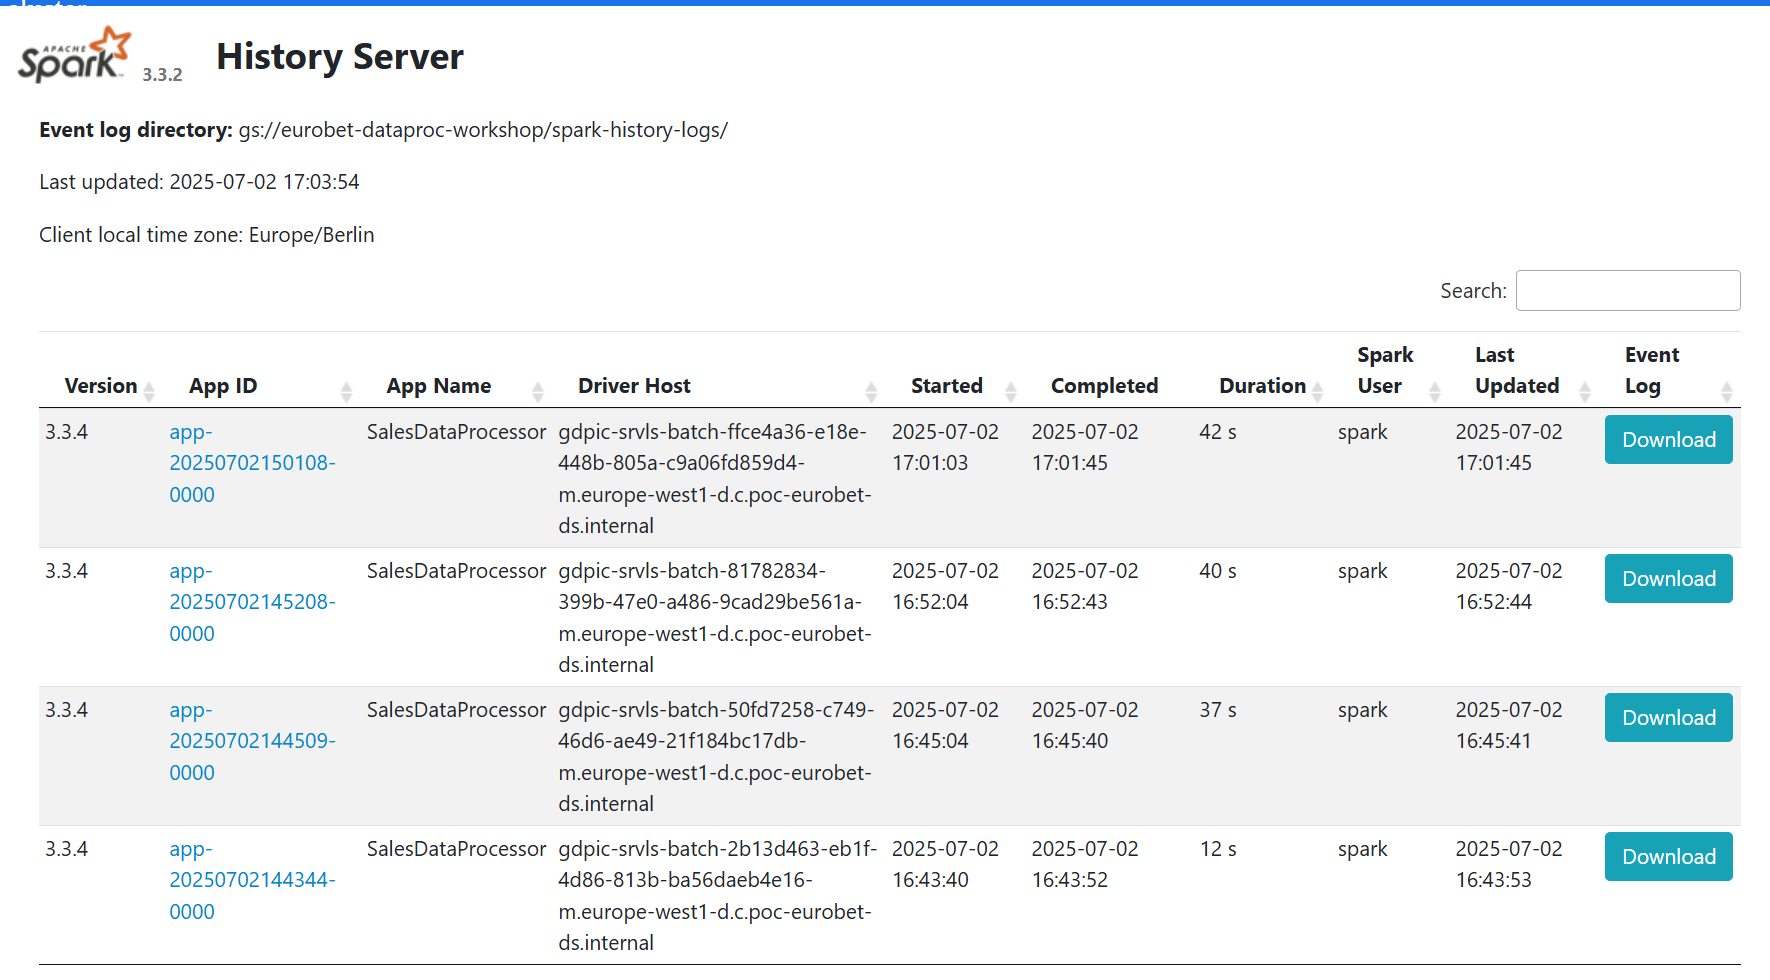

### 2. Check Spark Event Logs in GCS

Even if you can't access the UI, you can confirm if your jobs are actually writing event logs:

1.  **Go to Cloud Storage:**
    * Open the Google Cloud Console.
    * Navigate to **Cloud Storage > Buckets**.
    * Go to the bucket where you configured Spark event logs to be stored (e.g., `gs://example-dataproc-workshop/spark-history-logs/`).

2.  **Look for Application Directories:**
    * Inside that bucket, you should see directories named after your Spark application IDs (e.g., `application_1751462491831_0004`).
    * Within these directories, you'll find the Spark event log files. This confirms your jobs are correctly emitting the logs.

### 3. Check Job Logs (stdout/stderr)

For a specific batch job, you can see its stdout/stderr (which includes your `print` statements) directly:

1.  **Go to Dataproc Batches:**
    * Open the Google Cloud Console.
    * Navigate to **Dataproc > Serverless > Batches**.
    * Find your specific batch job ID (e.g., `51249c66614f45f59beeb594289d5ca1`).
    * Click on its ID to go to the batch job details page.
    * On this page, you'll see a "Logs" section or tab. This provides the standard output and error streams from your PySpark driver and potentially executors. This is where you would see your `print(f"Spark config for temporaryGcsBucket: ...")` statement if you added it.

By following these steps, you can verify if your history server is working and if your jobs are successfully logging their execution details.

When you access the Spark History Server UI, you're looking at a powerful tool for **diagnosing, understanding, and optimizing your Spark applications**. It visualizes the event logs generated by your Spark jobs, providing insights into their execution.

Here's a guide on how to read and interpret the information typically presented in the Spark History Server UI:

### I. Navigating the UI: The Main Tabs

Upon opening the UI for a specific application, you'll see several tabs at the top. Each tab provides a different level of detail:

1.  **Jobs Tab:**
    * **What it shows:** An overview of all Spark jobs executed within your application. A "job" typically corresponds to an action (like `show()`, `write()`, `count()`) on a DataFrame.
    * **Key Information:**
        * **Job ID:** Unique identifier for each job.
        * **Description:** A high-level description of the action.
        * **Submitted, Started, Completed Time:** Timestamps for job lifecycle.
        * **Duration:** How long the job took.
        * **Stages:** Number of stages within the job (completed/total).
        * **Tasks:** Number of tasks within the job (completed/total).
    * **How to Read:** Start here to get a high-level sense of your application's workload and overall success/failure. Click on a Job ID to drill down into its stages.

2.  **Stages Tab:**
    * **What it shows:** A detailed view of all stages within your application. Stages are physical execution units that correspond to computation that can be run in parallel on a cluster. They are separated by shuffles.
    * **Key Information:**
        * **DAG Visualization:** This is crucial. It shows the Directed Acyclic Graph (DAG) of how stages are connected and how data flows. Look for wide dependencies (shuffle stages) which are expensive.
        * **Stage ID & Description:** Identify specific parts of your logic.
        * **Tasks:** Number of tasks (total, completed, active, failed, skipped).
        * **Input/Output/Shuffle Read/Shuffle Write:** Critical metrics for data movement.
        * **Duration, GC Time, Scheduler Delay, Task Time:** Performance indicators.
        * **Aggregated Metrics:** Sums of metrics across all tasks in the stage.
    * **How to Read:** This is where you diagnose most performance issues.
        * **Long-running stages:** Identify which stages are taking the most time.
        * **Large shuffle writes/reads:** Indicate significant data movement across the network, which can be a bottleneck.
        * **High GC Time:** Suggests memory pressure.
        * **Skipped tasks:** Good, means Spark optimized by reusing cached data.
        * **Failed tasks:** Indicate issues; drill down further into task details for stack traces.

3.  **Tasks Tab (within a Stage View):**
    * **What it shows:** Individual task metrics for a selected stage. A "task" is the smallest unit of work in Spark, running on one partition of data.
    * **Key Information:**
        * **Task ID:** Unique ID.
        * **Executor ID & Host:** Which executor ran the task.
        * **Duration:** Individual task execution time.
        * **Input Size / Rows Read, Output Size / Rows Written:** Data processed by the task.
        * **Shuffle Read / Write:** Data shuffled by this specific task.
        * **Error/Exception:** If a task failed, this column will show details.
    * **How to Read:**
        * **Stragglers:** Look for tasks with significantly higher durations than others in the same stage (highlighted in red or orange). These "stragglers" can bottleneck the entire stage.
        * **Data Skew:** If one task has vastly more "Input Size" or "Shuffle Read" than others in the same stage, it might indicate data skew, where one partition has much more data.
        * **Task Failures:** Click on failed tasks to see the full stack trace and error message, which is crucial for debugging code issues.

4.  **Executors Tab:**
    * **What it shows:** Resource utilization and performance statistics for each executor (worker node) in your cluster.
    * **Key Information:**
        * **Executor ID & Host:** Identify specific machines.
        * **Active/Failed Tasks:** How many tasks ran or failed on that executor.
        * **Total Cores / Memory:** Resources allocated.
        * **Shuffle Read/Write, Tasks, Duration:** Overall metrics.
        * **Storage Memory (Used/Total):** How much memory is used for caching RDDs/DataFrames.
        * **GC Time:** Total time spent in Java garbage collection.
    * **How to Read:**
        * **Resource Usage:** See if executors are efficiently utilized.
        * **Uneven Distribution:** If one executor has a disproportionately high number of tasks or much longer duration, it might indicate a problem with resource allocation or data distribution.
        * **High GC Time:** Indicates the executor is spending too much time cleaning up memory, suggesting memory constraints or inefficient code.

5.  **Environment Tab:**
    * **What it shows:** All the Spark configuration properties, system properties, and classpath details that were in effect when the application ran.
    * **How to Read:** Useful for confirming that your Spark properties (like `spark.bigquery.temporaryGcsBucket`, `spark.executor.memory`, `spark.sql.shuffle.partitions`, `spark.eventLog.dir`) were correctly applied. This is often the first place to look if a configuration you set doesn't seem to be taking effect.

6.  **SQL Tab (if applicable for Spark SQL jobs):**
    * **What it shows:** Details about Spark SQL queries executed, including their logical and physical plans.
    * **How to Read:** Examine the physical plan to understand how Spark is executing your SQL queries. Look for inefficient operations like full table scans on large tables without filters or excessive shuffles.

### II. Key Metrics to Focus On for Optimization

* **Duration:** The total time taken for a job or stage. Aim to reduce this.
* **Input Size / Rows Read:** How much data is being read. Larger input often means longer processing.
* **Shuffle Read/Write:** Amount of data being written to/read from disk and transferred over the network between stages. High shuffle is often a bottleneck.
* **GC Time:** Time spent in garbage collection. High GC time means your JVMs are struggling with memory, often leading to pauses and poor performance.
* **Task Skew:** Look for uneven task durations or data processing (e.g., one task processing 100GB while others process 10MB).
* **Errors/Failures:** Crucial for debugging. Always check the stack trace associated with failed tasks.

By methodically going through these tabs and understanding what each metric means, you can gain deep insights into your Spark applications and effectively troubleshoot or optimize them.